In [1]:
import pandas as pd #for manipulating data
import numpy as np #for manipulating data
import sklearn #for building models
import xgboost as xgb #for building models
import sklearn.ensemble #for building models
from sklearn.model_selection import train_test_split #for creating a hold-out sample
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino
import matplotlib.pyplot as plt #for custom graphs at the end
import seaborn as sns #for custom graphs at the end
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

c:\Users\Riccardo\anaconda3\envs\py39_ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
def transform_date(df, drop=True):
    df['time'] = pd.to_datetime(df['time'])
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    if drop == True:
        return df.drop(columns={'time'})
    else:
        return df

def add_lags(df, target_col,  max_period:int, min_period:int,name='ndvi'):
    dataframe = pd.DataFrame()
    for i in range(max_period, min_period, -1):
        dataframe[f"{name}_t-" + str(i)] = df[target_col].shift(i)
        final_df = pd.concat([df, dataframe], axis=1)
        final_df.dropna(inplace=True)
    return final_df
    

In [49]:
data = pd.read_csv(r'../data/final_dataset_ndvi_spi.csv').drop(columns=['arc_xy'])
data['fips'] = data[['lat','lon']].astype(str).apply(lambda x: ','.join(x), axis=1).astype('category').cat.codes
df = data[(data.lon.between(32,42)) & (data.lat.between(6,16))]

dataframe = pd.DataFrame()
for i in range(54, 0, -1):
   dataframe['ndvi_t-' + str(i)] = df.ndvi.shift(i)
final_df = pd.concat([df, dataframe], axis=1)
final_df.dropna(inplace=True)

from sklearn.model_selection import TimeSeriesSplit
final_df.set_index('time', inplace=True)
tss = TimeSeriesSplit(n_splits=5, test_size=52*25, gap=4)
final_df = final_df.sort_index()


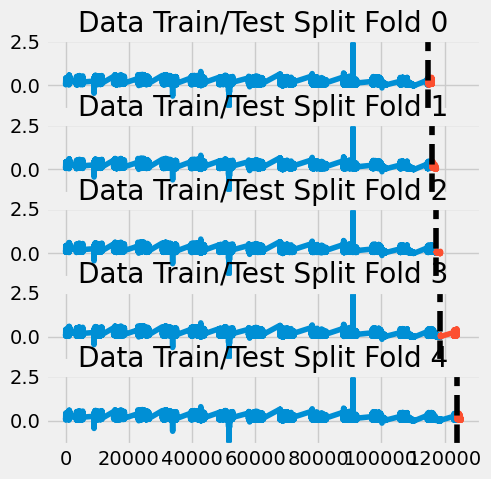

In [51]:
fig, axs = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(final_df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['ndvi'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['ndvi'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [58]:
tss = TimeSeriesSplit(n_splits=5, test_size=52*25, gap=4)
final_df = final_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(final_df):
    train = final_df.iloc[train_idx]
    test = final_df.iloc[val_idx]

    train = transform_date(train.reset_index(), drop=False).set_index('time')
    test = transform_date(test.reset_index(),drop=False).set_index('time')

    FEATURES = [col for col in final_df.columns if col not in ['ndvi','ndvi_t-4',
       'ndvi_t-3', 'ndvi_t-2', 'ndvi_t-1','fips']]
    TARGET = 'ndvi'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:59:11] WARNING: D:\bld\xgboost-split_1667849704519\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.33757	validation_1-rmse:0.37433
[100]	validation_0-rmse:0.14166	validation_1-rmse:0.16364
[200]	validation_0-rmse:0.08290	validation_1-rmse:0.09094
[300]	validation_0-rmse:0.06907	validation_1-rmse:0.06712
[400]	validation_0-rmse:0.06555	validation_1-rmse:0.05829
[500]	validation_0-rmse:0.06412	validation_1-rmse:0.05469
[600]	validation_0-rmse:0.06320	validation_1-rmse:0.05309
[700]	validation_0-rmse:0.06250	validation_1-rmse:0.05235
[800]	validation_0-rmse:0.06190	validation_1-rmse:0.05185
[900]	validation_0-rmse:0.06136	validation_1-rmse:0.05150
[999]	validation_0-rmse:0.06095	validation_1-rmse:0.05118
[22:00:34] WARNING: D:\bld\xgboost-split_1667849704519\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.33848	validation_1-rmse:0.33

In [59]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0676
Fold scores:[0.051169623884286836, 0.0625151363369325, 0.064666314280681, 0.08420811565205677, 0.07551623611964581]


In [65]:
# Retrain on all data
temp_df = transform_date(final_df.reset_index(), drop=False).set_index('time')

FEATURES = [col for col in temp_df.columns if col not in ['ndvi','ndvi_t-4',
       'ndvi_t-3', 'ndvi_t-2', 'ndvi_t-1']]
TARGET = 'ndvi'

X_all = temp_df[FEATURES]
y_all = temp_df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=700,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[22:08:29] WARNING: D:\bld\xgboost-split_1667849704519\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.33693
[100]	validation_0-rmse:0.14157
[200]	validation_0-rmse:0.08289
[300]	validation_0-rmse:0.06879
[400]	validation_0-rmse:0.06515
[500]	validation_0-rmse:0.06367
[600]	validation_0-rmse:0.06267
[699]	validation_0-rmse:0.06189


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)